In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

In [3]:
# File loading

DIR = "/content/drive/MyDrive/ML_project/data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
print("Images: " + str(len(df.index)) + ", classes: " + str(len(df.groupby(['category']).count())) + ", super classes: " + str(len(df.groupby(['super_category']).count())))

Images: 6739, classes: 20, super classes: 19


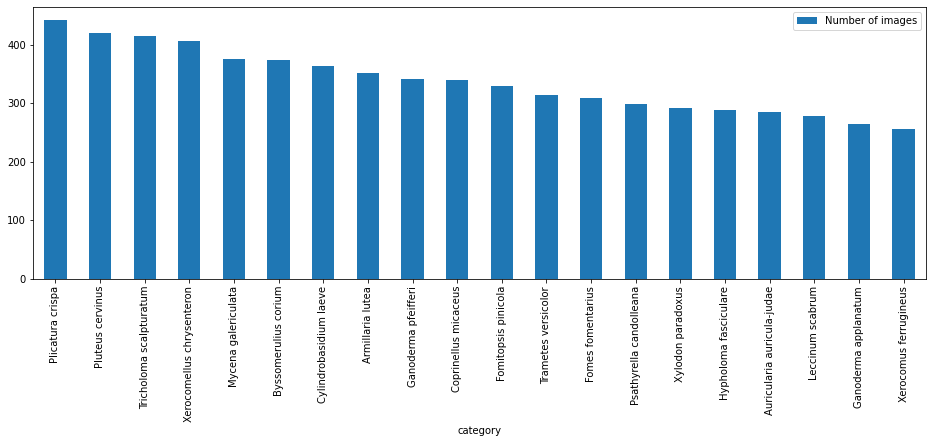

In [5]:
df_grouped = df.groupby(['category']).count().rename(columns={'path':'count'})[['count']]
df_sorted = df_grouped.sort_values(by='count', ascending=False)
fig, ax = plt.subplots()
df_sorted.plot(ax=ax, kind='bar', figsize=(16,5))
ax.legend(["Number of images"])
plt.show()

In [ ]:
MOBILENET_V2 = 'mobilenetv2'
XCEPTION = 'xception'

# Global parameters

MODEL = XCEPTION
N_CLASSES = 3
SAMPLES_PER_CLASS = 414
TRAINING_SIZE_RATIO = 0.8
VALIDATION_SIZE_RATIO = 0.2
IMG_SIZE = (224, 224) if MODEL == MOBILENET_V2 else (299, 299)
BATCH_SIZE = 32             # if None is 32 (default)
LEARNING_RATE = 0.0001
PATIENCE = 10

In [ ]:
reference = 'category'

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:N_CLASSES].iterrows():
    size = min(SAMPLES_PER_CLASS, df.loc[df[reference] == i].shape[0])
    training_size = int(size*TRAINING_SIZE_RATIO)
    validation_size = int(training_size*VALIDATION_SIZE_RATIO)

    tmp_df = df.loc[df[reference] == i].iloc[:training_size-validation_size]
    tmp_df['split'] = 'train'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size-validation_size:training_size]
    tmp_df['split'] = 'val'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size:SAMPLES_PER_CLASS]
    tmp_df['split'] = 'test'
    df1 = df1.append(tmp_df)

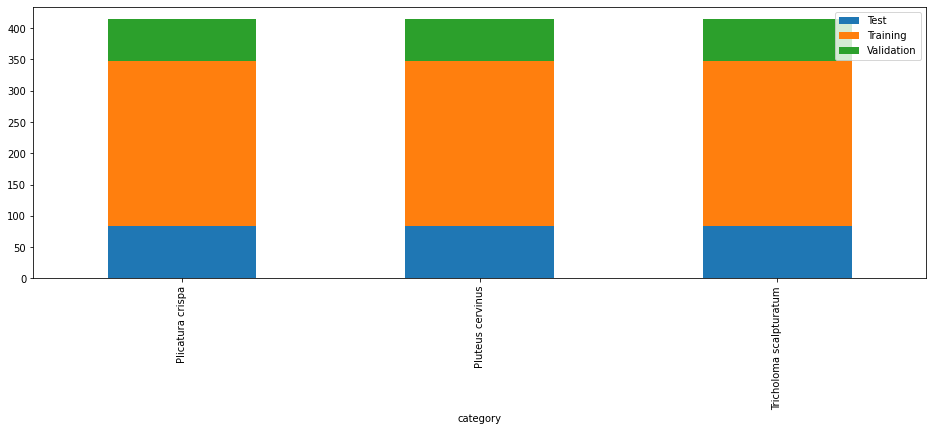

count          
split                    test train val
category                               
Plicatura crispa           83   265  66
Pluteus cervinus           83   265  66
Tricholoma scalpturatum    83   265  66

In [ ]:
df_count = df1.groupby(['category','split']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('split')
fig, ax = plt.subplots()
df_count.plot(kind='bar', ax=ax, stacked=True, figsize=(16,5))
ax.legend(["Test", "Training", "Validation"])
plt.show()

df_count

In [ ]:
df_training = df1.loc[df1['split'] == 'train']
df_validation = df1.loc[df1['split'] == 'val']
df_test = df1.loc[df1['split'] == 'test']

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])
print("Test set:", df_test.shape[0])

Training set: 795
Validation set: 198
Test set: 249


In [ ]:
DIR = os.getcwd()

training_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 795 validated image filenames belonging to 3 classes.


In [ ]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 198 validated image filenames belonging to 3 classes.


In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 249 validated image filenames belonging to 3 classes.


In [ ]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

In [ ]:
# From https://www.tensorflow.org/tutorials/images/transfer_learning

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet') if MODEL == MOBILENET_V2 \
            else tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input if MODEL == MOBILENET_V2 \
            else tf.keras.applications.xception.preprocess_input

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_2 True
sequential True
tf.math.truediv True
tf.math.subtract True
xception False
global_average_pooling2d True
dropout True
dense True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy','top_k_categorical_accuracy'])

In [ ]:
def elapsed_time(start_time):
    delta = time.time()-start_time
    hours = int(delta/(60*60))
    delta -= hours*(60*60)
    minut = int(delta/60)
    delta -= minut*60
    sec = int(delta)
    return (hours, minut, sec)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start_time = time.time()

history = model.fit(train_generator, epochs=100, batch_size=BATCH_SIZE,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("Elapsed time: %ih %im %is" % training_time)

#model.load_weights(checkpoint_filepath)
#model.save('/content/drive/MyDrive/ML_project/model.h5')

Epoch 1/100
25/25 [==============================] - 223s 9s/step - loss: 1.0986 - accuracy: 0.3687 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0267 - val_accuracy: 0.4495 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
25/25 [==============================] - 13s 523ms/step - loss: 1.0009 - accuracy: 0.5400 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9600 - val_accuracy: 0.5808 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/100
25/25 [==============================] - 13s 522ms/step - loss: 0.9192 - accuracy: 0.6258 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9035 - val_accuracy: 0.6414 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/100
25/25 [==============================] - 13s 525ms/step - loss: 0.8711 - accuracy: 0.6722 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8552 - val_accuracy: 0.6667 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/100
25/25 [==============================] - 13s 518ms/step - loss: 0.8110 - accuracy: 0.7232 - top_k_cate

In [ ]:
def plot_learning_curves(history, history_fine=False):

  if history_fine:
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    start_fine_tuning = len(history.history['accuracy'])
  else:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


  fig, axes = plt.subplots(1, 2, figsize=(16,5))

  # summarize history for accuracy
  axes[0].plot(acc, label='Training Accuracy')
  axes[0].plot(val_acc, label='Validation Accuracy')
  if history_fine:
    axes[0].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[0].set_title('Model accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
  axes[0].set_xlabel('Epoch')
  axes[0].legend(loc='lower right')

  # summarize history for loss
  axes[1].plot(loss, label='Training Loss')
  axes[1].plot(val_loss, label='Validation Loss')
  if history_fine:
    axes[1].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[1].set_title('Model loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(loc='upper right')

  plt.show()

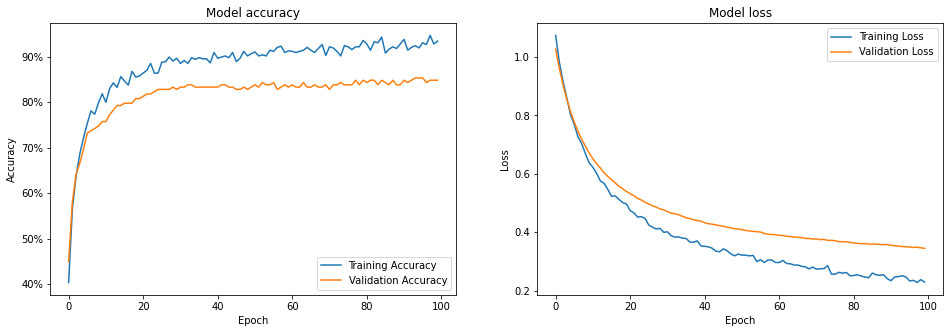

In [ ]:
plot_learning_curves(history)

In [ ]:
test_loss, test_acc, _ = model.evaluate(test_generator)

8/8 [==============================] - 52s 7s/step - loss: 0.2971 - accuracy: 0.8835 - top_k_categorical_accuracy: 1.0000


In [ ]:
def print_classification_report_and_confusion_matrix():
  
  Y_pred = model.predict(test_generator, df_test.shape[0] // BATCH_SIZE+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('Classification Report')
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

  df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), 
                      index = [i for i in classes],
                      columns = [i for i in classes])
  plt = sn.heatmap(df_cm, annot=True, cmap="Blues")
  plt.set_ylabel("Real") 
  plt.set_xlabel("Predicted")
  plt.set_xticklabels(plt.get_xticklabels(), rotation=-30, ha="left") 

Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       0.98      0.95      0.96        83
       Pluteus cervinus       0.83      0.83      0.83        83
Tricholoma scalpturatum       0.85      0.87      0.86        83

               accuracy                           0.88       249
              macro avg       0.88      0.88      0.88       249
           weighted avg       0.88      0.88      0.88       249



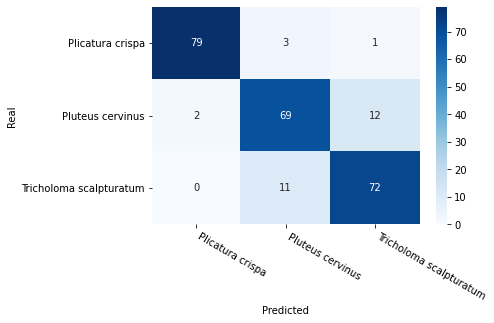

In [ ]:
print_classification_report_and_confusion_matrix()

In [ ]:
# Fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
start_time = time.time()

history_fine = model.fit(train_generator, 
                    epochs=len(history.history['accuracy']) + 20,
                    initial_epoch=history.epoch[-1],
                    batch_size=BATCH_SIZE,
                    validation_data = validation_generator,
                    verbose=1, 
                    callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("\nElapsed time: %ih %im %is" % training_time)

Epoch 100/120
25/25 [==============================] - 19s 599ms/step - loss: 0.4800 - accuracy: 0.8032 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3259 - val_accuracy: 0.8636 - val_top_k_categorical_accuracy: 1.0000
Epoch 101/120
25/25 [==============================] - 14s 559ms/step - loss: 0.4070 - accuracy: 0.8457 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3307 - val_accuracy: 0.8333 - val_top_k_categorical_accuracy: 1.0000
Epoch 102/120
25/25 [==============================] - 14s 556ms/step - loss: 0.2994 - accuracy: 0.9029 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.8333 - val_top_k_categorical_accuracy: 1.0000
Epoch 103/120
25/25 [==============================] - 14s 561ms/step - loss: 0.2483 - accuracy: 0.9270 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3510 - val_accuracy: 0.8384 - val_top_k_categorical_accuracy: 1.0000
Epoch 104/120
25/25 [==============================] - 14s 558ms/step - loss: 0.2564 - accuracy: 0.9279 

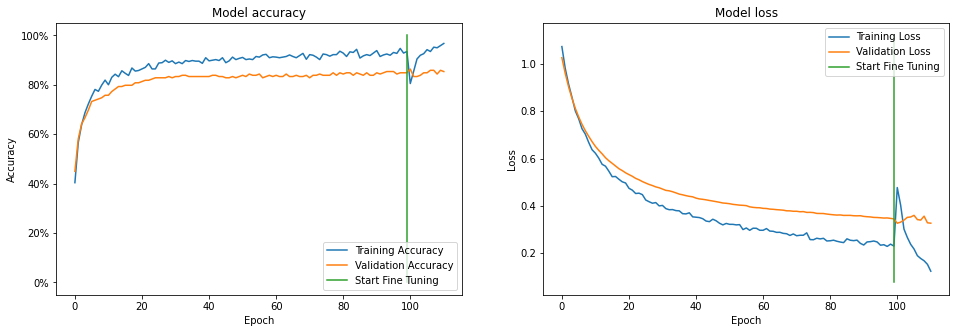

In [ ]:
plot_learning_curves(history, history_fine)

In [ ]:
test_loss, test_acc, _ = model.evaluate(test_generator)

8/8 [==============================] - 4s 427ms/step - loss: 0.2884 - accuracy: 0.8956 - top_k_categorical_accuracy: 1.0000


Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       0.98      0.95      0.96        83
       Pluteus cervinus       0.79      0.94      0.86        83
Tricholoma scalpturatum       0.96      0.80      0.87        83

               accuracy                           0.90       249
              macro avg       0.91      0.90      0.90       249
           weighted avg       0.91      0.90      0.90       249



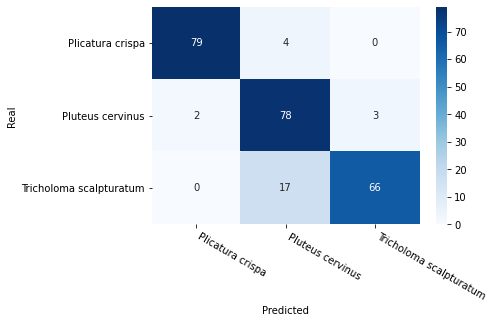

In [ ]:
print_classification_report_and_confusion_matrix()

Found 60 validated image filenames belonging to 3 classes.


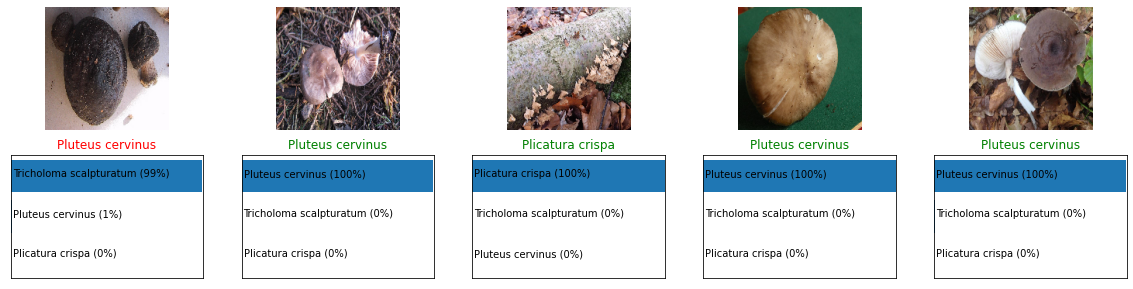

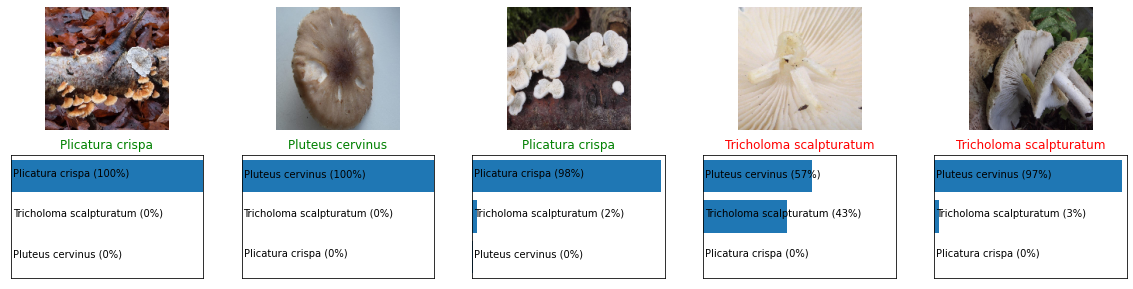

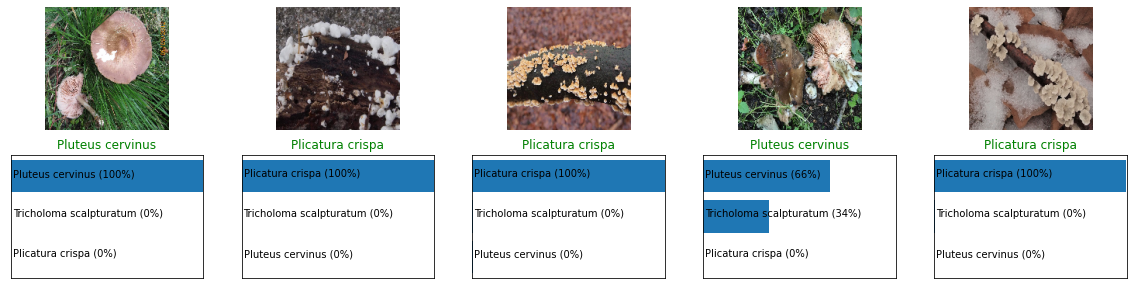

In [ ]:
# Making some random predicions

# Shuffle the generator to obtain random images
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

iters = 0
n_predictions = 12
n_cols = 5
    
for i, batch in enumerate(test_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(20,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k].astype(np.uint8))
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()